In [ ]:
# Importing all the required libraries

import os
import numpy as np
import pandas as pd

#classifier
from sklearn.tree import DecisionTreeClassifier

#For test-train split
from sklearn.model_selection import train_test_split

#metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix, f1_score

#For test-train split
from sklearn.model_selection import train_test_split

#Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

import warnings
warnings.filterwarnings("ignore")

# word cloud
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# TF
from sklearn.feature_extraction.text import CountVectorizer
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# word2vec
from gensim.models import KeyedVectors
# PCA
from sklearn.decomposition import PCA, IncrementalPCA
# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 1.Reading the Data

In [ ]:
# Reading the file

file = open("SMSSpamCollection", "r")
file_data = file.readlines()

In [ ]:
# Reading the data to a dataframe as Labels and SMS

df = pd.DataFrame([line.split('\t') for line in file_data] ,columns=['Labels', 'SMS'])

df.head()

,Labels,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...\n
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 2.Text Pre-processing 

## Introduction and methodology.
* Before using the raw data from the source we need to do some preprocessing on the text data.
* This helps in creating a better model by eliminating unnecessary contents in the data.
* Different steps in pre processing are listed in the cell below with codes

In [ ]:
# 1) dropping duplicates
df = df.drop_duplicates().reset_index(drop=True)

# 2) removing the \n at the end  as it is not part of the text.
df.SMS = [sms.rstrip('\n') for sms in df.SMS] 

# 3) Normalizing - we're not normalizing all the texts to lower case as there's higher chance of usage of capital letters in spam 
# messages. For example 'FREE' would appear a lot in spam messages. But normal messages also contains 'free' but not in capital.
# Words like these two needs to be separately handled.
# df.SMS = [sms.lower() for sms in df.SMS] 

# 4) Removing punctuation - we're not doing it as spam messages have high chance of usage of punctions.
# p = string.punctuation
# remv_punc = str.maketrans("", "", p)
# df.SMS = [sms.translate(remv_punc) for sms in df.SMS] 

# 5) NLTK stopword list - These words can be avoided
nltk.download('stopwords')
stop_words = stopwords.words("english")
print('No of stop words:', len(stop_words) )
# Removing stopwords from all the SMS
df.SMS = [" ".join([w for w in sms.split() if w not in stop_words])  for sms in df.SMS] 

# 6) Removing un neccesary white splaces.
for i in range(len(df.SMS)):
    df.SMS[i] = df.SMS[i].replace("  ", " ").strip()
    
# 7) Lemmatization - We cqn group together the different inflected forms of a word that has the same meaning.
# Put it in try except. Won't work even with nltk installed in some machines.
try:
    lemmatizer = WordNetLemmatizer()
    df.SMS = [" ".join([lemmatizer.lemmatize(w) for w in sms.split()]) for sms in df.SMS] 
except LookupError:
    print('wordnet library error. Lemmetization not working.')

[nltk_data] Downloading package stopwords to
[nltk_data]     F:\anaconda3\share\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


No of stop words: 179
wordnet library error. Lemmetization not working.


## Observations
* 403 duplicate rows were removed
* '\n' was present in all the sentences. It was removed.
* Stop words and extra white spaces were removed.

# 3.Data Exploration

## Introduction and methodology.

* Word clouds are useful in observing visually which words are mostly being used in the spam and ham messages
* We're using the WordCloud library for plotting the word cloud

In [ ]:
# Number of ham and spam messages
df.Labels.value_counts()

ham     4518
spam     653
Name: Labels, dtype: int64

In [ ]:
# Spam and ham sms. Create emty array for wordcloud creation
ham =[]
spam =[]
for i in range(len(df)):
        
        #based on the tag, move to ham or spam array.
        if df.Labels[i] == 'ham':
            ham.extend(df.SMS[i].split())
        else:
            spam.extend(df.SMS[i].split())

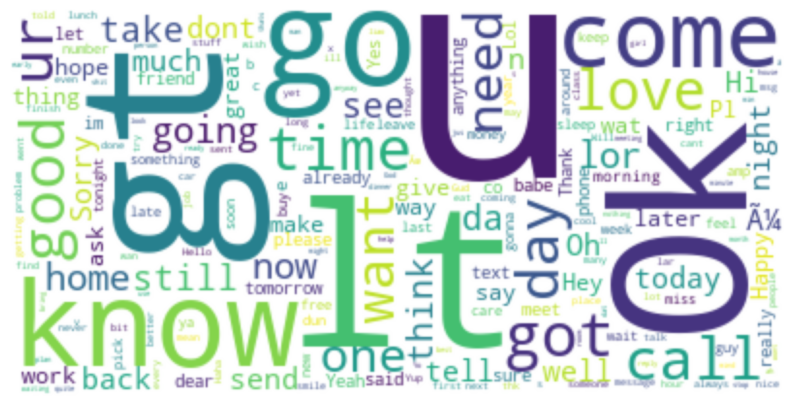

In [ ]:
#Wordcloud for ham tweets
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(ham))
plt.figure(figsize=(10,12))
plt.imshow(word_cloud, interpolation='gaussian')
plt.axis("off")
plt.show()

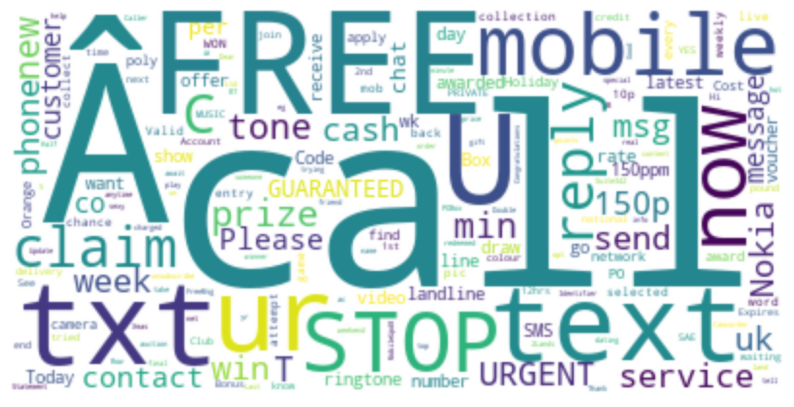

In [ ]:
#Wordcloud for spam tweets
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(spam))
plt.figure(figsize=(10,12))
plt.imshow(word_cloud, interpolation='gaussian')
plt.axis("off")
plt.show()

## Observations
* As it is clearly visible from the data that 'FREE', 'prize', 'call', 'URGENT' etc are in most of the spam messages.
* The ham messages contains regular words we use in conversations

# 4.Vectorization

## Introduction and methodology.

* Inorder to do any classification model we need to convert this text data into numerical data 
* There are different methods available for this
* TF - Term frequency
* TF IDF - Term Frequency - Inverse Document frequency
* Google's word2vec vectorization
* Below sections 4.a to 4.c contains different vectorization methods. 4.d is trying with new features added. 

## 4.a Vectorization using TF.

In [ ]:
#using count vectoroizer to create a document-term matrix

count = CountVectorizer()
bag_of_words = count.fit_transform(df.SMS)

# Show feature matrix
bag_of_words = bag_of_words.toarray()

# Get feature names
feature_names = count.get_feature_names()

#Converting the document-term matrix to a dataframe

DTM_TF = pd.DataFrame(bag_of_words, columns=feature_names)
DTM_TF.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zoe,zogtorius,zoom,zouk,zyada,ãº1,ã¼,ãœ,éˆ,œharry
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4.b Vectorization using TF-IDF.

In [ ]:
# UsingTF-IDF vectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_vectors = tfidf_vectorizer.fit_transform(df.SMS)

names = tfidf_vectorizer.get_feature_names()

tfidf_vectors = tfidf_vectors.toarray()

# Moving the resulting tf idf vector to a dataframe

tfidf_df = pd.DataFrame(tfidf_vectors, columns=names)
tfidf_df.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zoe,zogtorius,zoom,zouk,zyada,ãº1,ã¼,ãœ,éˆ,œharry
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.c Vectorization using Google's word2vec.

In [ ]:
embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary = True)

In [ ]:
# final word to vec dataframe
w2v_df = pd.DataFrame() 

for sms in df.SMS:
    temp = pd.DataFrame()  
    for word in sms.split(): 
        try:
            word_vec = embeddings[word] 
            temp = temp.append(pd.Series(word_vec), ignore_index = True) 
        except:
            pass
    doc_vector = temp.mean() 
    w2v_df = w2v_df.append(doc_vector, ignore_index = True)

w2v_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.025018,0.059943,-0.039404,0.171118,0.013245,0.062183,0.024356,-0.089038,0.000360,0.100043,...,-0.023730,-0.036066,-0.122485,0.102979,0.047974,0.004956,0.051611,-0.073950,-0.043994,0.076355
1,-0.111053,0.078430,0.049194,0.071575,-0.064575,0.022217,-0.091959,-0.034348,-0.045685,0.053040,...,0.142578,0.127563,-0.175903,-0.051208,-0.089661,-0.292725,-0.123840,-0.118896,-0.070862,0.019592
2,-0.020883,-0.095270,-0.085255,-0.026496,0.079046,-0.036765,-0.027710,-0.114057,0.055765,0.120875,...,0.013751,-0.017564,-0.085934,-0.022116,0.000337,-0.004193,-0.030216,-0.071676,-0.119646,-0.022073
3,-0.069380,0.066210,0.136405,0.102966,-0.092773,-0.058072,-0.146973,-0.167550,-0.005371,0.077288,...,0.009399,0.058838,-0.026655,-0.037005,-0.065674,-0.074568,-0.105443,0.015276,0.016183,0.185529
4,0.055315,0.049504,0.044582,0.158779,0.009347,0.045088,0.084630,-0.126256,0.098450,0.083697,...,-0.068403,0.059152,-0.174840,0.085275,-0.088948,-0.057478,0.040702,-0.077545,0.110456,-0.016410


## 4.d Generate some heuristic features like “presence of phone number’, etc.

In [ ]:
# Heuristic features like 'presence of a phone number in an sms is being checked.'

df_with_hfeatures = df.copy()
df_with_hfeatures['PhNo_Present'] = 0

# Go though each sms and see if it has a number greater than 100000000. This is mostly likely a phone number.
for i in range(len(df.SMS)):
    phone_number_found = False
    tokenized_sms = df.SMS[i].split()
    for word in tokenized_sms:
        try:
            word = int(word)
            if word > 100000000:
                phone_number_found = True 
                
                # break the loop once a hone number is obtained.
                break
        except:
            pass
        
    # add the flag 1 to the PhNo_Present column if it is present
    if phone_number_found:
        df_with_hfeatures.loc[i,'PhNo_Present'] = 1
        
df_with_hfeatures

,Labels,SMS,PhNo_Present
0,ham,"Go jurong point, crazy.. Available bugis n gre...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,0
3,ham,U dun say early hor... U c already say...,0
4,ham,"Nah I think goes usf, lives around though",0
...,...,...,...
5166,spam,This 2nd time tried 2 contact u. U Â£750 Pound...,1
5167,ham,Will Ã¼ b going esplanade fr home?,0
5168,ham,"Pity, * mood that. So...any suggestions?",0
5169,ham,The guy bitching I acted like i'd interested b...,0


## Observations

* All vectors were successfully created.
* TF vectorization is only a frequency count (TF)
* TF-IDF  incorporates any sort of inverse document frequency (IDF)
* Word2vec creates a 300 length vector for each word. Here for doc2vec we are taking the average of these words in a sentence.

# Preparing data for further steps

In [ ]:
#Creating the target variable
y = [1 if x == 'spam' else 0 for x in df.Labels]

DTM_TF_X = DTM_TF.copy()
tfidf_df_X = tfidf_df.copy()
w2v_df_X = w2v_df.copy()

DTM_TF['y'] = y
tfidf_df['y'] = y
w2v_df['y'] = y    

#drop null rows. (it happens in word2vec library when it cannot find any of the words)
w2v_df.dropna(inplace=True)

w2v_df_X = w2v_df.drop('y', axis =1)

# 5.Dimension Reduction

## Introduction and methodology.

* Here we are using principal component analysis for dimension reduction. We've Other mehods as well which will used in 5.c
* We'll be keeping the number of components that explains at least 95% of the overall variance.
* We'll do it separately or each of the resulting vectorization dataframes we created.

## 5.a Dimension reduction using PCA. (Keeping the number of components that explains at least 95% of the overall variance.)

### 5.a.1 On TF

In [ ]:
# PCA transform
pca = PCA()
pca_df_tf = pd.DataFrame(pca.fit_transform(DTM_TF_X))
pca_df_tf.columns = ['PC'+str(i) for i in range(len(pca_df_tf.columns))]

# Selecting > 95% explained varaince
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
n_comp = np.argmax(var_cumu>95)
print('auto selected components count: ',n_comp)

pca_df_tf = pca_df_tf.iloc[:,:n_comp]
pca_df_tf.head()

auto selected components count:  2031


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC2021,PC2022,PC2023,PC2024,PC2025,PC2026,PC2027,PC2028,PC2029,PC2030
0,-0.088289,-0.251552,-0.055082,-0.056925,-0.112334,-0.057534,-0.050944,0.234242,0.874430,0.149708,...,-0.018907,0.024479,-0.002835,0.011516,-0.002694,-0.024763,0.036607,0.013034,-0.015406,-0.010779
1,-0.101721,-0.237883,-0.161785,-0.154975,0.014681,-0.089885,-0.090963,-0.008201,0.174929,0.040907,...,0.011077,0.012785,0.026689,-0.007391,-0.009219,-0.020659,-0.004381,-0.003764,-0.002420,0.012481
2,-0.122904,0.502950,-0.601992,0.554023,-0.287379,-0.155705,0.604434,-0.541356,0.124084,-0.301601,...,0.008644,0.020197,0.007838,-0.003851,0.005542,0.005550,0.007306,-0.020104,-0.011642,0.010924
3,-0.098557,-0.229384,-0.073883,-0.114746,0.014725,-0.054572,-0.057702,-0.032634,0.087453,-0.042968,...,0.053331,0.024790,0.001300,-0.023035,0.016556,0.008765,0.007680,0.002930,-0.011792,0.010079
4,-0.071371,-0.194664,-0.034934,-0.095193,0.046661,-0.057482,0.064102,-0.040583,-0.121007,-0.059367,...,0.009188,-0.031117,-0.015786,0.013191,-0.025023,0.008578,-0.035162,0.061567,0.000835,0.008216


### 5.a.2 On TF-IDF

In [ ]:
# PCA transform
pca = PCA()
pca_df_tfidf = pd.DataFrame(pca.fit_transform(tfidf_df_X))
pca_df_tfidf.columns = ['PC'+str(i) for i in range(len(pca_df_tfidf.columns))]

# Selecting > 95% explained varaince
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
n_comp = np.argmax(var_cumu>95)
print('auto selected components count: ',n_comp)

pca_df_tfidf = pca_df_tfidf.iloc[:,:n_comp]
pca_df_tfidf.head()

auto selected components count:  2800


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC2790,PC2791,PC2792,PC2793,PC2794,PC2795,PC2796,PC2797,PC2798,PC2799
0,-0.020732,0.020719,-0.041652,-0.037262,-0.020778,0.050480,-0.060505,-0.007958,-0.025566,-0.041709,...,0.007426,-0.009968,-0.002432,0.012656,0.004702,-0.001594,-0.011639,0.001833,-0.002078,0.001565
1,-0.045770,0.240369,0.060123,0.068233,-0.030404,-0.042490,0.004551,-0.001932,-0.013504,0.001073,...,-0.000029,-0.007970,0.006120,-0.010826,-0.011534,0.000826,0.004139,0.000308,-0.000019,-0.008483
2,-0.016313,-0.033190,0.049198,-0.057084,-0.039529,-0.070302,-0.008768,0.071551,-0.017260,-0.034715,...,-0.006627,0.011497,0.003149,0.000836,-0.002937,-0.008935,0.007198,-0.007709,-0.004273,-0.010042
3,-0.024559,0.029243,-0.043167,-0.031937,-0.027338,0.036806,-0.071534,-0.015909,0.007380,0.013832,...,-0.013707,0.005071,0.008794,0.004217,-0.009662,-0.014136,-0.015854,0.024119,0.034919,0.008506
4,0.005693,-0.012905,-0.043666,0.003767,0.018147,-0.033556,-0.005880,-0.007180,-0.004306,0.016688,...,0.002285,0.003164,0.003862,0.006701,0.006154,0.003657,0.007533,-0.008724,-0.003569,-0.002558


### 5.a.3 On Word2vec

In [ ]:
# PCA transform
pca = PCA()
pca_df_w2v = pd.DataFrame(pca.fit_transform(w2v_df_X))
pca_df_w2v.columns = ['PC'+str(i) for i in range(len(pca_df_w2v.columns))]

# Selecting > 95% explained varaincevvvvvv
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
n_comp = np.argmax(var_cumu>95)
print('auto selected components count: ',n_comp)

pca_df_w2v = pca_df_w2v.iloc[:,:n_comp]
pca_df_w2v.head()

auto selected components count:  221


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC211,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,PC220
0,0.404643,-0.017984,-0.051422,0.286291,0.160124,0.019587,-0.142604,-0.136270,-0.002001,0.140053,...,-0.009461,0.005733,0.010358,0.001319,-0.037539,-0.003110,0.018599,-0.032782,-0.033917,0.054875
1,0.185575,0.989545,-0.092475,0.282086,0.011317,0.242228,0.104246,0.002230,0.030997,-0.071157,...,0.002110,0.039506,-0.040723,-0.023471,-0.019435,-0.050939,0.128472,-0.071834,0.039304,-0.038022
2,0.570228,-0.259805,-0.076123,0.175630,-0.132710,-0.084905,-0.040210,-0.196672,0.049025,0.238048,...,-0.075986,0.047087,0.025524,-0.007729,-0.014599,-0.002617,0.047318,0.010560,-0.063881,-0.051996
3,0.417149,0.018865,-0.331877,-0.054739,0.028165,0.194498,-0.280902,-0.004473,0.105729,-0.073700,...,-0.003979,-0.074398,0.028527,-0.017984,-0.053386,0.007337,-0.033324,0.031714,0.019983,0.002142
4,-0.503453,0.047060,-0.224832,-0.120057,0.058075,-0.069607,-0.042665,0.059670,-0.057954,0.035294,...,0.003118,-0.024739,-0.050091,0.031663,-0.004271,0.024023,0.004895,0.026260,-0.003289,0.044702


## 5.b Visualizing the data across the first two PCs. 
Colour encodings for the labels for better visualization are used.

### 5.b.1 on TF

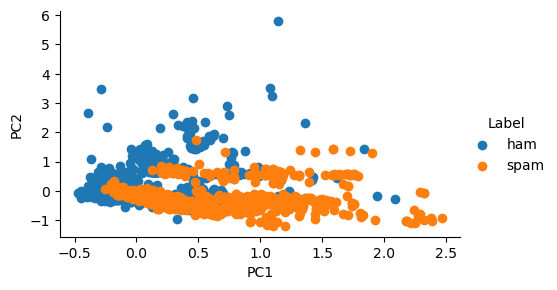

In [ ]:
#Visualizing the words using PC1 and PC2

# Add the label to pca df for visualization
pca_df_tf['Label']= ['spam' if y ==1 else 'ham' for y in DTM_TF['y'] ]

fg = sns.FacetGrid(data=pca_df_tf, hue='Label', aspect=1.61)
fg.map(plt.scatter, 'PC1', 'PC2').add_legend()
plt.show()

### 5.b.2 on TF-IDF

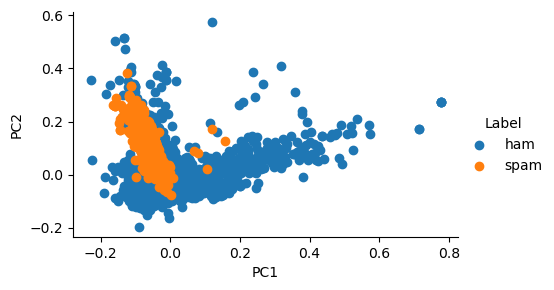

In [ ]:
#Visualizing the words using PC1 and PC2

# Add the label to pca df for visualization
pca_df_tfidf['Label']= ['spam' if y ==1 else 'ham' for y in tfidf_df['y'] ]

fg = sns.FacetGrid(data=pca_df_tfidf, hue='Label', aspect=1.61)
fg.map(plt.scatter, 'PC1', 'PC2').add_legend()
plt.show()

### 5.b.2 on Word2vec

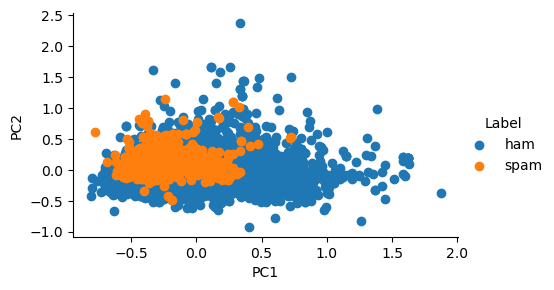

In [ ]:
#Visualizing the words using PC1 and PC2

# Add the label to pca df for visualization
pca_df_w2v['Label']= ['spam' if y ==1 else 'ham' for y in w2v_df['y'] ]

fg = sns.FacetGrid(data=pca_df_w2v, hue='Label', aspect=1.61)
fg.map(plt.scatter, 'PC1', 'PC2').add_legend()
plt.show()

## 5.c Other heuristic approaches for dimension reduction as well like dropping texts that appear in less than p% of the documents.

* Here we're reducing the dimentions (ie number of words) by the proportion of their appearence in the dataset. If it is lower than 0.01% we'll remove it.)

In [ ]:
# Dimension reduction by proportion
DTM_TF_X_prop = DTM_TF_X.copy()
tfidf_df_X_prop = tfidf_df_X.copy()
w2v_df_X_prop = w2v_df_X.copy()

#using count vectoroizer to create a document-term matrix
dtm_sum = np.sum(np.sum(DTM_TF_X))
#Remove terms that is contained in less than 0.01% of the documents
drop_these = DTM_TF_X.columns[DTM_TF_X.apply(lambda x: np.sum(x)/dtm_sum, axis=0) < 0.0001]

# The final dimension reduced dataframes are:
DTM_TF_X_prop.drop(drop_these,axis=1, inplace=True)
tfidf_df_X_prop.drop(drop_these,axis=1, inplace=True)

In [ ]:
print('No of dimensions reduced: ', DTM_TF_X.shape[1] - DTM_TF_X_prop.shape[1])

No of dimensions reduced:  7289


auto selected components count:  875


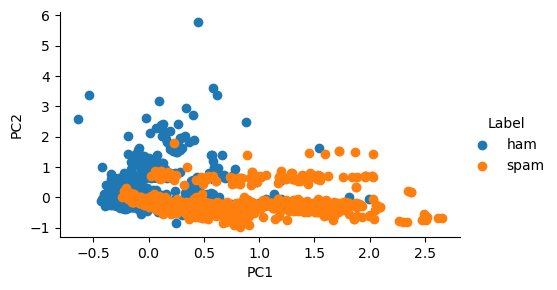

In [ ]:
# Adding the heuristic feature to the TF reduced by proportion dataframe.

DTM_TF_X_prop['PhNo_Present'] = df_with_hfeatures.PhNo_Present
DTM_TF_X_prop.fillna(0, inplace=True)

# PCA transform for plotting
pca = PCA()
pca_df_tf_reduced = pd.DataFrame(pca.fit_transform(DTM_TF_X_prop))
pca_df_tf_reduced.columns = ['PC'+str(i) for i in range(len(pca_df_tf_reduced.columns))]

# Selecting > 95% explained varaince
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
n_comp = np.argmax(var_cumu>95)
print('auto selected components count: ',n_comp)

pca_df_tf_reduced = pca_df_tf_reduced.iloc[:,:n_comp]
pca_df_tf_reduced.head()

# Plotting the graph
pca_df_tf_reduced['Label']= ['spam' if y ==1 else 'ham' for y in DTM_TF['y'] ]

fg = sns.FacetGrid(data=pca_df_tf_reduced, hue='Label', aspect=1.61)
fg.map(plt.scatter, 'PC1', 'PC2').add_legend()
plt.show()

## Observations.

* TF is bit spread in the plots
* TF IDF and Word2vec concentrates the spam messages. This is because of the cosine similarities.
* Using dimension reduction by proportion we were able to get rid of 7602 words that appears in less than 0.01% of the data

# 6.Spam Filters

## Introduction and methodology.

* We're using classification machine learning models like Logistic Regression, Decision Tree, Bagging, Boosting, Random Forest, SVM, etc to create a Spam filter.
* From the best models obtained in step 1 by modeling all with the previous 3 vecotorized dataframes. We'll be going for hyper parameter tuning in 6.b
* All the scores and confusion matrices of the models will be displayed with the model for easy comparison.
* Then finally we'll choose the best model and fit it on test data.

## 6.a Models

In [ ]:
# this is a general function to split the input X and y
def spliting(X, y):
    
    # keep random state same so everything will be validated equally
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=0)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test 

# this is a general functtion to print confusion matrix
def print_cm(model_name, y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(2, 2))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

    plt.xlabel('Predictions', fontsize=8)
    plt.ylabel('Actuals', fontsize=8)
    plt.title(model_name + ' Confusion Matrix',fontsize=8)
    plt.show()

# This is a general function to run differnet models with a single call.
def fit_models(X_train, X_valid, y_train, y_valid):
    
    # All results will be saved to this temporary dataset and will be returned.
    result = pd.DataFrame(columns=['Model','Validationn accuracy','Precision','recall score','F1 score'])
    
    # LogisticRegression
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred_valid = model.predict(X_valid)
    
    
    model_name = 'LogisticRegression'
    
    # calculating differnet scores and storing in result dataframe
    result.loc[len(result),] = [model_name, accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), 
                                recall_score(y_valid, y_pred_valid),
                               f1_score(y_valid, y_pred_valid)]
    
    # calling confusion matrix print function
    print_cm(model_name ,y_valid, y_pred_valid)
    
    # DecisionTreeClassifier
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    y_pred_valid = model.predict(X_valid)
    
    
    model_name = 'DecisionTreeClassifier'
    
    # calculating differnet scores and storing in result dataframe
    result.loc[len(result),] = [model_name, accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), 
                                recall_score(y_valid, y_pred_valid),
                               f1_score(y_valid, y_pred_valid)]
    
    print_cm(model_name ,y_valid, y_pred_valid)
    
    # BaggingClassifier
    model = BaggingClassifier()
    model.fit(X_train, y_train)
    
    y_pred_valid = model.predict(X_valid)
    
    
    model_name = 'BaggingClassifier'
    
    # calculating differnet scores and storing in result dataframe
    result.loc[len(result),] = [model_name, accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), 
                                recall_score(y_valid, y_pred_valid),
                               f1_score(y_valid, y_pred_valid)]
    
    # calling confusion matrix print function
    print_cm(model_name ,y_valid, y_pred_valid)
    
    # GradientBoostingClassifier
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    
    y_pred_valid = model.predict(X_valid)
    
    
    model_name ='GradientBoostingClassifier'
    
    # calculating differnet scores and storing in result dataframe
    result.loc[len(result),] = [model_name, accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), 
                                recall_score(y_valid, y_pred_valid),
                               f1_score(y_valid, y_pred_valid)]
    
    # calling confusion matrix print function
    print_cm(model_name ,y_valid, y_pred_valid)
    
    # SVC
    model = SVC()
    model.fit(X_train, y_train)
    
    y_pred_valid = model.predict(X_valid)
    
    
    model_name = 'SVC'
    
    # calculating differnet scores and storing in result dataframe
    result.loc[len(result),] = [model_name,accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), 
                                recall_score(y_valid, y_pred_valid),
                               f1_score(y_valid, y_pred_valid)]
    
    # calling confusion matrix print function
    print_cm(model_name ,y_valid, y_pred_valid)   
    
    # RandomForestClassifier
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    y_pred_valid = model.predict(X_valid)
    
    
    model_name = 'RandomForestClassifier'
    
    # calculating differnet scores and storing in result dataframe
    result.loc[len(result),] = [model_name,accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), 
                                recall_score(y_valid, y_pred_valid),
                               f1_score(y_valid, y_pred_valid)]
    
    # calling confusion matrix print function
    print_cm(model_name ,y_valid, y_pred_valid)
     
    #return the results dataframe
    return result

### 6.a.1 On TF

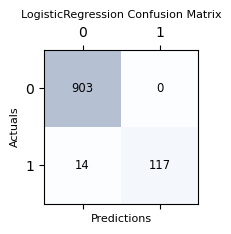

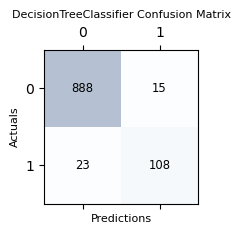

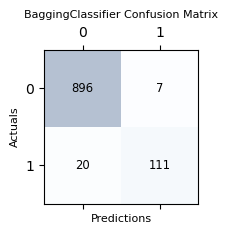

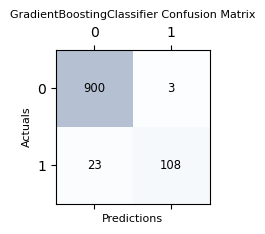

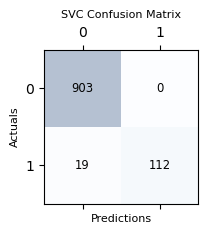

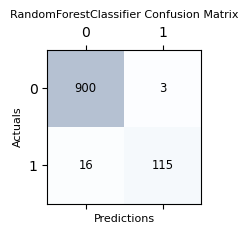

In [ ]:
# 1. TF - Running the models on DTM matrix created by TF

X = DTM_TF_X_prop
y = DTM_TF['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

result_tf = fit_models(X_train, X_valid, y_train, y_valid)

# adding one more column to dintiguish results later
result_tf.insert(loc = 0 , column ='Vectorizing method', value ='TF')

### 6.a.2 on TFIDF

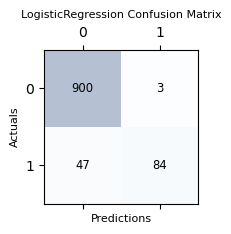

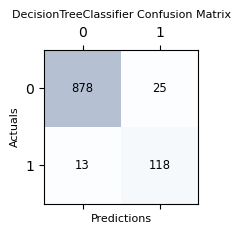

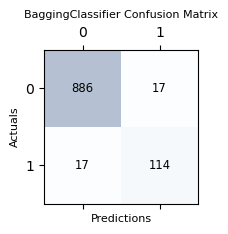

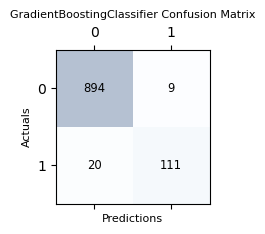

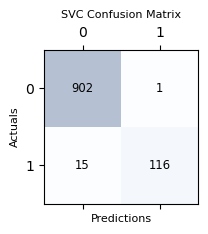

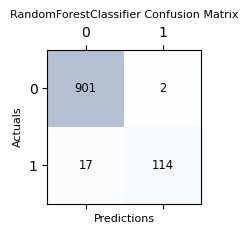

In [ ]:
# 2. TF-IDF - Running the models on vector matrix created by TF-IDF
X = tfidf_df_X_prop
y = tfidf_df['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

result_tfidf = fit_models(X_train, X_valid, y_train, y_valid)

# adding one more column to dintiguish results later
result_tfidf.insert(loc = 0 , column ='Vectorizing method', value ='TF-IDF')

### 6.a.3 on Word2vec

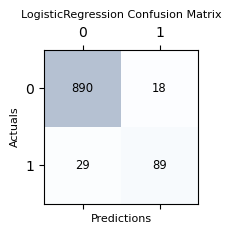

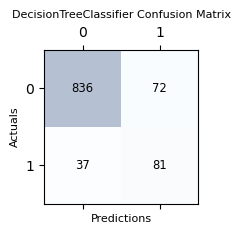

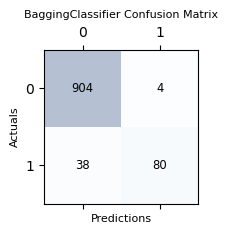

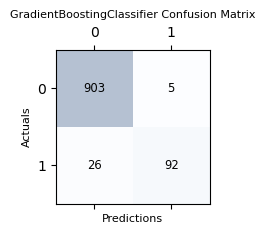

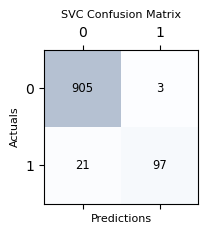

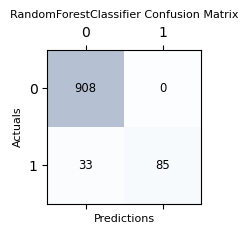

In [ ]:
# 3. Word2vec - Running the models on DTM matrix created by Word2vec

X = w2v_df.drop('y',axis =1)
y = w2v_df['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

result_w2v = fit_models(X_train, X_valid, y_train, y_valid)

# adding one more column to dintiguish results later
result_w2v.insert(loc = 0 , column ='Vectorizing method', value = 'Word2vec')

In [ ]:
# Final results sorted by the F1 score given by the validations

final_result =pd.concat((result_tf,result_tfidf, result_w2v), ignore_index=True)
final_result.sort_values('F1 score', ascending=False)

,Vectorizing method,Model,Validationn accuracy,Precision,recall score,F1 score
0,TF,LogisticRegression,0.98646,1.0,0.89313,0.943548
10,TF-IDF,SVC,0.984526,0.991453,0.885496,0.935484
5,TF,RandomForestClassifier,0.981625,0.974576,0.877863,0.923695
11,TF-IDF,RandomForestClassifier,0.981625,0.982759,0.870229,0.923077
4,TF,SVC,0.981625,1.0,0.854962,0.921811
3,TF,GradientBoostingClassifier,0.974855,0.972973,0.824427,0.892562
2,TF,BaggingClassifier,0.973888,0.940678,0.847328,0.891566
16,Word2vec,SVC,0.976608,0.97,0.822034,0.889908
9,TF-IDF,GradientBoostingClassifier,0.971954,0.925,0.847328,0.884462
8,TF-IDF,BaggingClassifier,0.967118,0.870229,0.870229,0.870229


## 6.b Hyperparameter tuning 

#### The best 4 models obtained above are
* TF-IDF	SVC
* TF-IDF	RandomForestClassifier
* TF	RandomForestClassifier
* TF	LogisticRegression

### 6.b.1 TUNING TF-IDF's SVC model

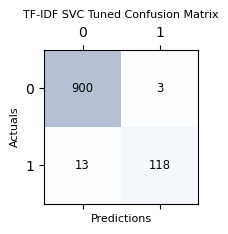

In [ ]:
X = tfidf_df_X_prop
y = tfidf_df['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0, scoring='f1')

# grid.fit(X_train, y_train)

# print('best parameters for TF-IDF\'s SVC model : ', grid.best_params_)

# This is time consuming to run again . The best parameters got were : {'C': 10, 'gamma': 1, 'kernel': 'rbf'} with .92 F1 score 

# Fitting with the best parameters.
model = SVC(C = 10, gamma=1, kernel='rbf')
model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)

# calculating differnet scores and storing in final results dataframe
final_result.loc[len(final_result),:] = ['TF-IDF','SVC tuned', accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), recall_score(y_valid, y_pred_valid),f1_score(y_valid, y_pred_valid)]

print_cm('TF-IDF SVC Tuned' ,y_valid, y_pred_valid)

### 6.b.2 TUNING TF-IDF's RandomForestClassifier model

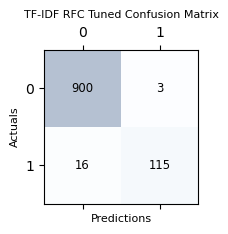

In [ ]:
X = tfidf_df_X_prop
y = tfidf_df['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

# param_grid = {'max_depth': range(1,150,30), 
#               'max_features': range(1,70,10)} 
  
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3, scoring='f1')

# grid.fit(X_train, y_train)

# print('best parameters for TF-IDF\'s RFClassifier model : ',grid.best_params_)

# Do not run again: time consuiming . Best obtained where 'max_depth': 61, 'max_features': 61

model = RandomForestClassifier(max_depth=61, max_features=61)
model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)

# calculating differnet scores and storing in final results dataframe
final_result.loc[len(final_result),:] = ['TF-IDF','RandomForestClassifier Tuned', accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), recall_score(y_valid, y_pred_valid),f1_score(y_valid, y_pred_valid)]

print_cm('TF-IDF RFC Tuned' ,y_valid, y_pred_valid)

### 6.b.3 TUNING TF's RandomForestClassifier model

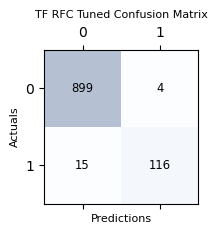

In [ ]:
X = DTM_TF_X_prop
y = DTM_TF['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

# param_grid = {'max_depth': range(1,150,30), 
#               'max_features': range(1,70,10)} 
  
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3, scoring='f1')

# grid.fit(X_train, y_train)

# print('best parameters for TF\'s RFClassifier model : ',grid.best_params_)

# Do not run again: time consuiming . Best obtained where {'max_depth': 121, 'max_features': 41}

model = RandomForestClassifier(max_depth=121, max_features=41)
model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)

# calculating differnet scores and storing in final results dataframe
final_result.loc[len(final_result),:] = ['TF','RandomForestClassifier Tuned', accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), recall_score(y_valid, y_pred_valid),f1_score(y_valid, y_pred_valid)]

print_cm('TF RFC Tuned' ,y_valid, y_pred_valid)

### 6.b.4 TUNING TF's LogisticRegression model

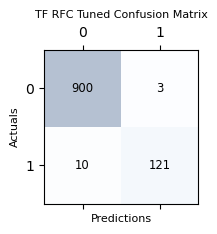

In [ ]:
X = DTM_TF_X_prop
y = DTM_TF['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

# # Creating the hyperparameter grid
# param_grid = {'C': np.logspace(-5, 8, 15)}
 
# # Instantiating the GridSearchCV object
# grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5, verbose = 3)
# grid.fit(X_train, y_train)

# Do not run again: time consuiming . Best obtained where {'C': 31.622776601683793}

model = LogisticRegression(C=31.622776601683793)
model.fit(X_train,y_train)
y_pred_valid = model.predict(X_valid)

# calculating differnet scores and storing in final results dataframe
final_result.loc[len(final_result),:] = ['TF','LogisticRegression Tuned', accuracy_score(y_valid, y_pred_valid), precision_score(y_valid, y_pred_valid), recall_score(y_valid, y_pred_valid),f1_score(y_valid, y_pred_valid)]

print_cm('TF RFC Tuned' ,y_valid, y_pred_valid)

## 6.c Final result and scores

In [ ]:
# All the model scores so far (including tuned)

final_result.sort_values('F1 score', ascending=False)

,Vectorizing method,Model,Validationn accuracy,Precision,recall score,F1 score
21,TF,LogisticRegression Tuned,0.987427,0.975806,0.923664,0.94902
0,TF,LogisticRegression,0.98646,1.0,0.89313,0.943548
18,TF-IDF,SVC tuned,0.984526,0.975207,0.900763,0.936508
10,TF-IDF,SVC,0.984526,0.991453,0.885496,0.935484
20,TF,RandomForestClassifier Tuned,0.981625,0.966667,0.885496,0.924303
5,TF,RandomForestClassifier,0.981625,0.974576,0.877863,0.923695
19,TF-IDF,RandomForestClassifier Tuned,0.981625,0.974576,0.877863,0.923695
11,TF-IDF,RandomForestClassifier,0.981625,0.982759,0.870229,0.923077
4,TF,SVC,0.981625,1.0,0.854962,0.921811
3,TF,GradientBoostingClassifier,0.974855,0.972973,0.824427,0.892562


In [ ]:
# The confusion matrices are printed above when each model is run.

### Final model
From the scores above we choose LogisticRegression Model on TF Vectorization as the final model.


 Final model is LogisticRegression Model on TF Vectorization

 Accuracy score on test data is : 0.9864734299516909

 Recall score on test data is : 0.9407407407407408

 Precision score on test data is : 0.9548872180451128

 F1 score on test data is : 0.9477611940298507


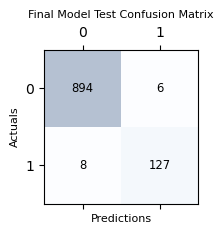

In [ ]:
# Final model data preparation

X = DTM_TF_X_prop
y = DTM_TF['y']

X_train, X_valid, X_test, y_train, y_valid, y_test = spliting(X, y)

# Fitting final model
final_model = LogisticRegression(C=31.622776601683793)
final_model.fit(X_train, y_train)

y_pred_test = final_model.predict(X_test)

print('\n Final model is LogisticRegression Model on TF Vectorization')

print('\n Accuracy score on test data is :', accuracy_score(y_test, y_pred_test))
print('\n Recall score on test data is :', recall_score(y_test, y_pred_test))
print('\n Precision score on test data is :', precision_score(y_test, y_pred_test))
print('\n F1 score on test data is :', f1_score(y_test, y_pred_test))

print_cm('Final Model Test' ,y_test, y_pred_test)

# Conclusion

* After running all the models we end with 4 good models with f1 score in ~ .90 range
* These 4 models were again hyper parameter tuned and they provided better results after the tuning.
* From the 4 tuned models, Logistic Regression on TF data gave the best f1 score on validation data (.93).
* This model was finally used as the Final model.
* In Test data , this model gave .93 f1 score. Which is very close to that on validation data.
* We can rule out the over fitting in our final model.
* The precision score on the data is 97.5%
* Accuracy score is 98%
* Our model is able to predict the spam SMSs efficiently.